In [1]:
import sys

import pandas as pd
import numpy as np

sys.path.insert(1, "../src/features")

import data_cleaning

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
OFFER_DATA_DIR = "../data/offer_acceptance_offers.csv"
ORDER_DATA_DIR = "../data/offer_acceptance_orders.csv"

offers = pd.read_csv(OFFER_DATA_DIR, low_memory=False)[["CARRIER_ID", "REFERENCE_NUMBER", "CREATED_ON_HQ", "RATE_USD", "OFFER_TYPE", "LOAD_DELIVERED_FROM_OFFER"]]
orders = pd.read_csv(ORDER_DATA_DIR, low_memory=False)[["REFERENCE_NUMBER", "ORDER_DATETIME_PST", "PICKUP_DEADLINE_PST", "ORIGIN_3DIGIT_ZIP", "DESTINATION_3DIGIT_ZIP", "APPROXIMATE_DRIVING_ROUTE_MILEAGE", "PALLETIZED_LINEAR_FEET"]]

In [3]:
offers = data_cleaning.change_to_date(offers, ["CREATED_ON_HQ"])
orders = data_cleaning.change_to_date(orders, ["ORDER_DATETIME_PST", "PICKUP_DEADLINE_PST"])

orders = data_cleaning.parse_zipcode(orders)

orders = data_cleaning.parse_datetime(orders)

offers = data_cleaning.flatten_ref_num(offers)
orders = data_cleaning.flatten_ref_num(orders)

In [4]:
merged = data_cleaning.join_offers_orders(offers, orders, how="inner")

merged = data_cleaning.get_remaining_time(merged)

merged = data_cleaning.during_business_hours(merged)

merged = data_cleaning.impute_mileage(merged)

merged = data_cleaning.get_business_hours(merged)

ModuleNotFoundError: No module named 'businesstimedelta'

In [ ]:
merged.head(1)

,CARRIER_ID,REFERENCE_NUMBER,CREATED_ON_HQ,RATE_USD,OFFER_TYPE,LOAD_DELIVERED_FROM_OFFER,ORDER_DATETIME_PST,PICKUP_DEADLINE_PST,ORIGIN_3DIGIT_ZIP,DESTINATION_3DIGIT_ZIP,...,DESTINATION_CITY,ORDER_DAY,ORDER_MONTH,ORDER_HOUR,PICKUP_DAY,PICKUP_MONTH,PICKUP_HOUR,REMAINING_TIME,BUSINESS_HOURS,BUSINESS_HOURS_ORDER_PICKUP
0,0629d63476c157a6cfe234f7a34422eb0ad94998c2d082...,ce3548db155049cc1ccce2da041cec607942e4f779fc2d...,2021-11-03 08:54:13,9546.0,pool,False,2021-11-02 12:56:49,2021-11-03 16:00:00,945,601,...,Chicago IL,1,11,12,2,11,16,25547.0,True,13.053056


In [15]:
num_offers = pd.Series(merged.groupby("REFERENCE_NUMBER")["CREATED_ON_HQ"].count().values)

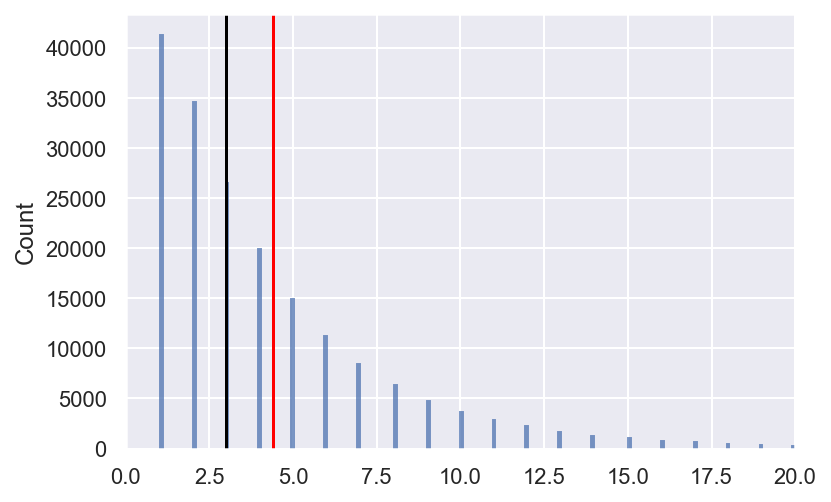

In [21]:
import seaborn as sns
sns.histplot(num_offers)
plt.xlim(0, 20)
plt.axvline(np.mean(num_offers), color="red")
plt.axvline(np.median(num_offers), color="black")

In [69]:
merged_usa = merged[merged["ORIGIN_3DIGIT_ZIP"].apply(lambda x: x.isnumeric())]
merged_usa = merged_usa[merged_usa["DESTINATION_3DIGIT_ZIP"].apply(lambda x: x.isnumeric())]
merged_usa = merged_usa.reset_index(drop=True)

In [208]:
import geopandas as gpd
import geoplot as gplt

# read 3 zipcode map data
usa = gpd.read_file("../data/zip3/zip3.shp")

# set map type
usa = usa.to_crs("EPSG:3395")

# add centroid coordinates
usa["x"], usa["y"] = usa.centroid.x, usa.centroid.y

# only show continental USA
usa = usa.query("STATE not in [\"HI\", \"AK\", \"PR\"]")
usa = usa[usa["x"]>-1.4*10**7]
usa = usa[usa["y"]>2.5*10**6]

# drop irrelevant columns
usa = usa[["ZIP3", "geometry", "x", "y"]]

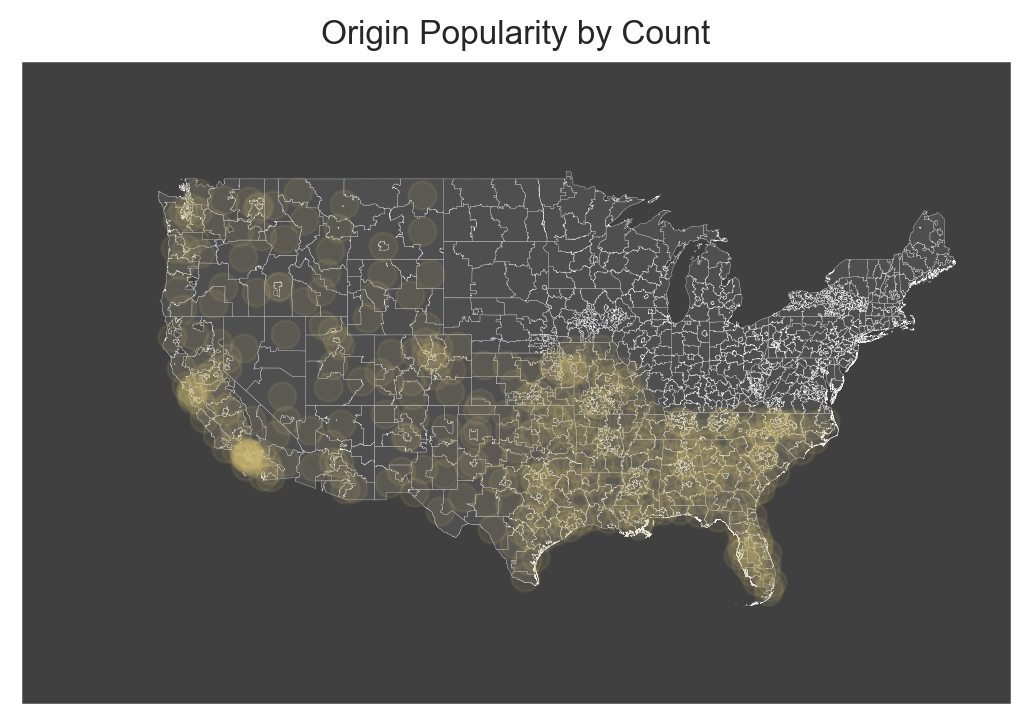

In [249]:
origin_geo = merged.groupby("ORIGIN_3DIGIT_ZIP").size().to_frame("count").merge(usa, left_on="ORIGIN_3DIGIT_ZIP", right_on="ZIP3")

ax = usa.plot(linewidth=0.1, facecolor= "#4F4F4F")
ax.scatter(origin_geo["x"], origin_geo["y"], marker=".", color="y", alpha=0.1, zorder=5, s=400)
ax.set_facecolor("#404040")
ax.grid(False)
plt.xlim([-1.5*10**7, -0.7*10**7])
plt.ylim([2*10**6, 7.2*10**6])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Origin Popularity by Count")
plt.show()

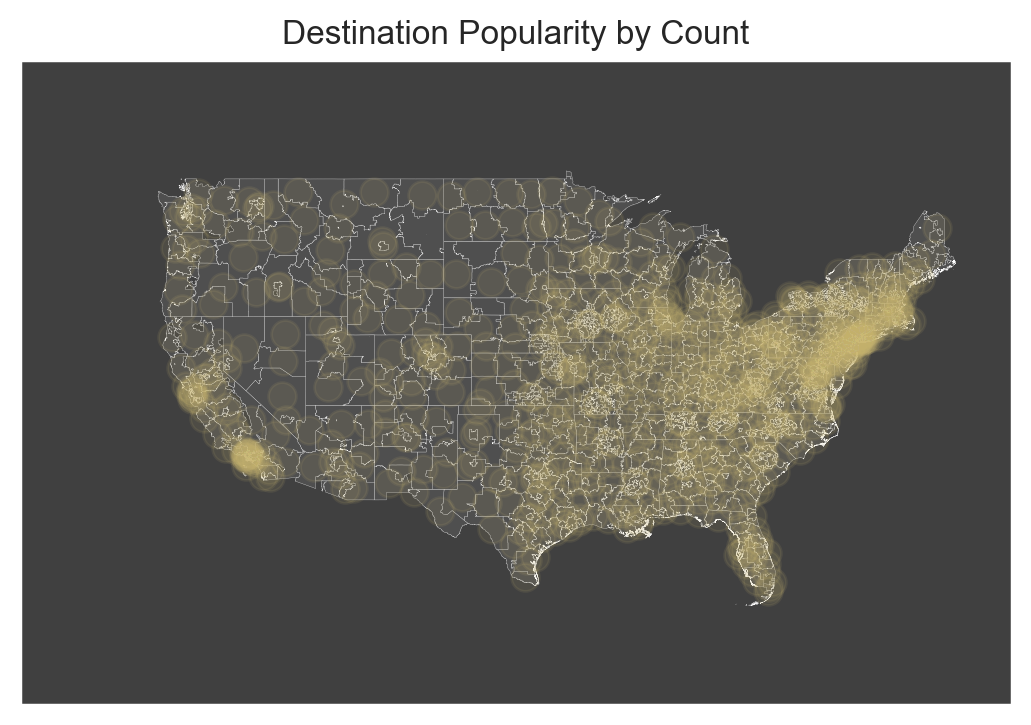

In [254]:
destination_geo = merged.groupby("DESTINATION_3DIGIT_ZIP").size().to_frame("count").merge(usa, left_on="DESTINATION_3DIGIT_ZIP", right_on="ZIP3")

ax = usa.plot(linewidth=0.1, facecolor= "#4F4F4F")
ax.scatter(destination_geo["x"], destination_geo["y"], marker=".", color="y", alpha=0.1, zorder=5, s=400)
ax.set_facecolor("#404040")
ax.grid(False)
plt.xlim([-1.5*10**7, -0.7*10**7])
plt.ylim([2*10**6, 7.2*10**6])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Destination Popularity by Count")
plt.show()

In [ ]:
destination_geo = merged.groupby("DESTINATION_3DIGIT_ZIP").size().to_frame("count").merge(usa, left_on="DESTINATION_3DIGIT_ZIP", right_on="ZIP3")

ax = usa.plot(linewidth=0.1, facecolor= "#4F4F4F")
ax.scatter(destination_geo["x"], destination_geo["y"], marker=".", color="y", alpha=0.1, zorder=5, s=400)
ax.set_facecolor("#404040")
ax.grid(False)
plt.xlim([-1.5*10**7, -0.7*10**7])
plt.ylim([2*10**6, 7.2*10**6])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("Destination Popularity by Count")
plt.show()

In [7]:
# filter FTL offers
unpooled_offers = offers[offers["OFFER_TYPE"] == "quote"]

# filter PTL offers
pooled_offers = offers[offers["OFFER_TYPE"] == "pool"]

In [8]:
print("Total of unpooled offers are: " + str(unpooled_offers.shape[0]))
print("Total of pooled offers are: " + str(pooled_offers.shape[0]))

Total of unpooled offers are: 594417
Total of pooled offers are: 243655


In [9]:
num_cols = merged[["RATE_USD", "APPROXIMATE_DRIVING_ROUTE_MILEAGE", 
                   "PALLETIZED_LINEAR_FEET", "REMAINIG_TIME", 
                   "BUSINESS_HOURS_ORDER_PICKUP"]]

<AxesSubplot:>

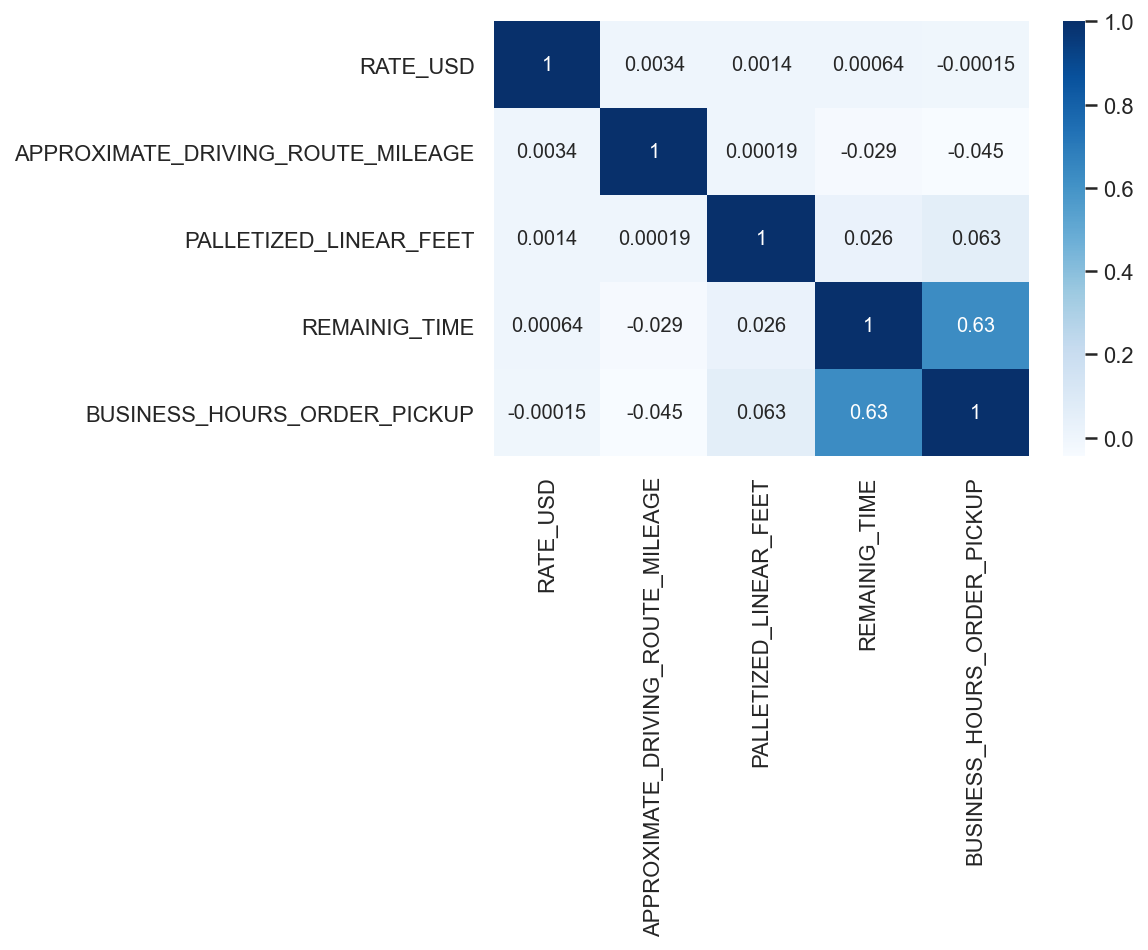

In [10]:
sns.heatmap(num_cols.corr(), cbar=True, annot=True, cmap='Blues')

Analysis:

First of all, we focused on all the numerical elements in the dataset because they are the most straightforward and contain useful information regarding the shipment. According to the heatmap, we noticed that APPROXIMATE_DRIVING_ROUTE_MILEAGE, and REMAINIG_TIME have positive correlations with RATE_USD because they have positive coefficients. BUSINESS_HOURS_ORDER_PICKUP has a negative correlations with RATE_USD because it has a negative coefficient.

In [11]:
Q1 = np.percentile(merged["RATE_USD"], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(merged["RATE_USD"], 75,
                   interpolation = 'midpoint')

IQR = Q3 - Q1

merged = merged[(merged["RATE_USD"] < (Q3 + 1.5 * IQR)) & 
                (merged["RATE_USD"] > Q1 - 1.5 * IQR)]

Some data have really large RATE_USD, so I used the percentile to remove the outliers for a better visualization.

Text(0.5, 1.0, 'Correlation Between Mileage and Rate')

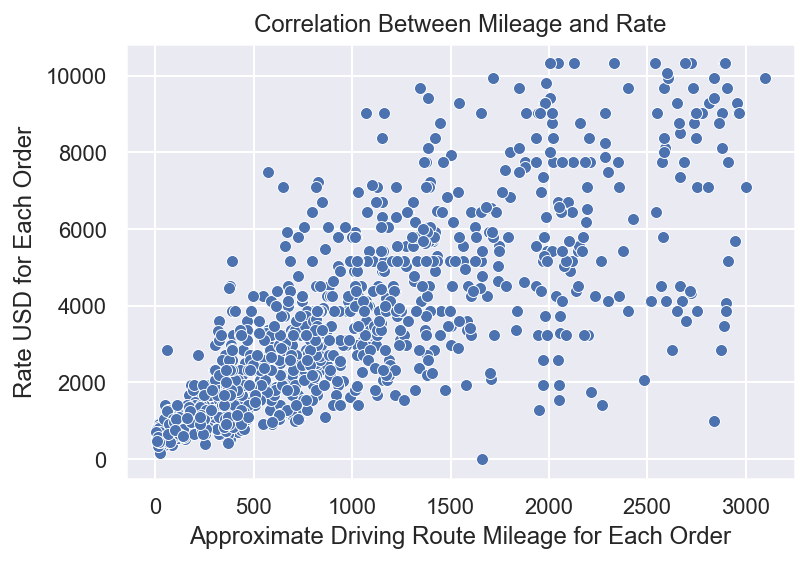

In [12]:
plot1 = sns.scatterplot(x='APPROXIMATE_DRIVING_ROUTE_MILEAGE', 
                        y='RATE_USD', data=merged.sample(n=1000))

plot1.set_xlabel("Approximate Driving Route Mileage for Each Order")
plot1.set_ylabel("Rate USD for Each Order")
plot1.set_title("Correlation Between Mileage and Rate")

Text(0.5, 1.0, 'Correlation Between Feet and Rate')

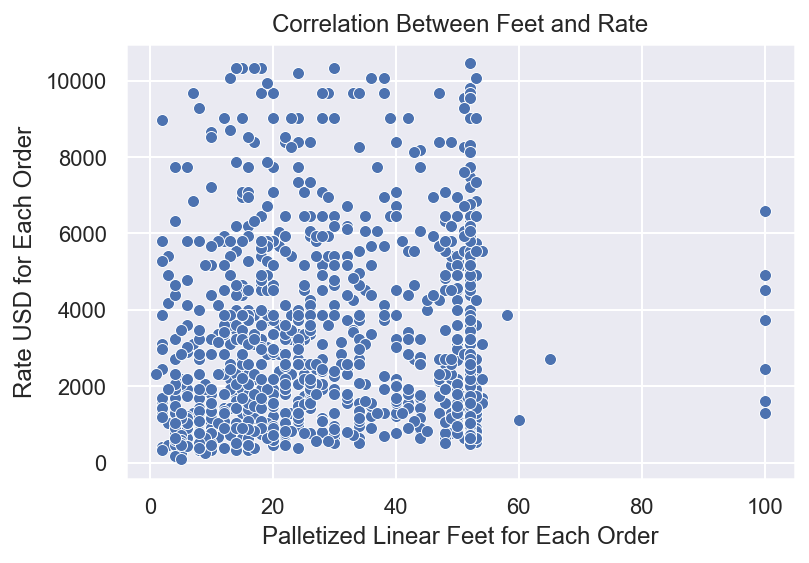

In [13]:
plot2 = sns.scatterplot(x='PALLETIZED_LINEAR_FEET', 
                        y='RATE_USD', data=merged.sample(n=1000))

plot2.set_xlabel("Palletized Linear Feet for Each Order")
plot2.set_ylabel("Rate USD for Each Order")
plot2.set_title("Correlation Between Feet and Rate")

Text(0.5, 1.0, 'Correlation Between Remaining Time and Rate')

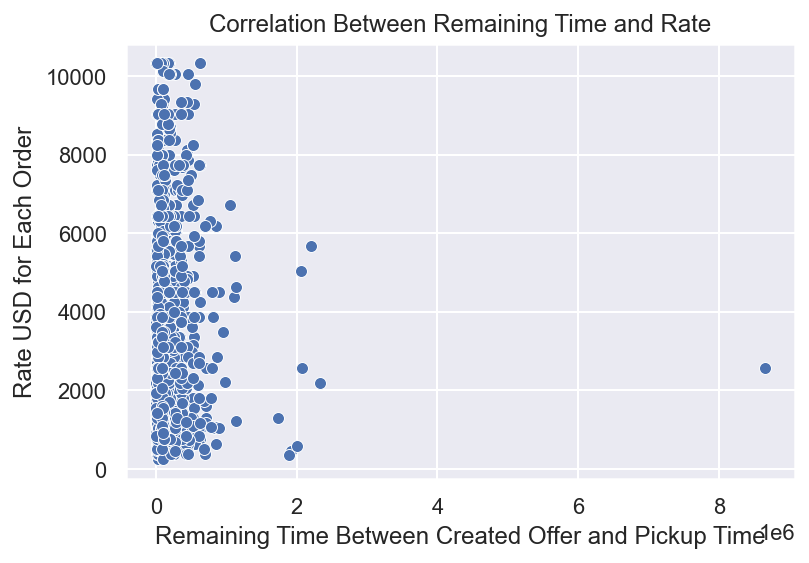

In [14]:
plot3 = sns.scatterplot(x='REMAINIG_TIME', 
                        y='RATE_USD', data=merged.sample(n=1000))

plot3.set_xlabel("Remaining Time Between Created Offer and Pickup Time")
plot3.set_ylabel("Rate USD for Each Order")
plot3.set_title("Correlation Between Remaining Time and Rate")

Text(0.5, 1.0, 'Correlation Between Business Hours and Rate')

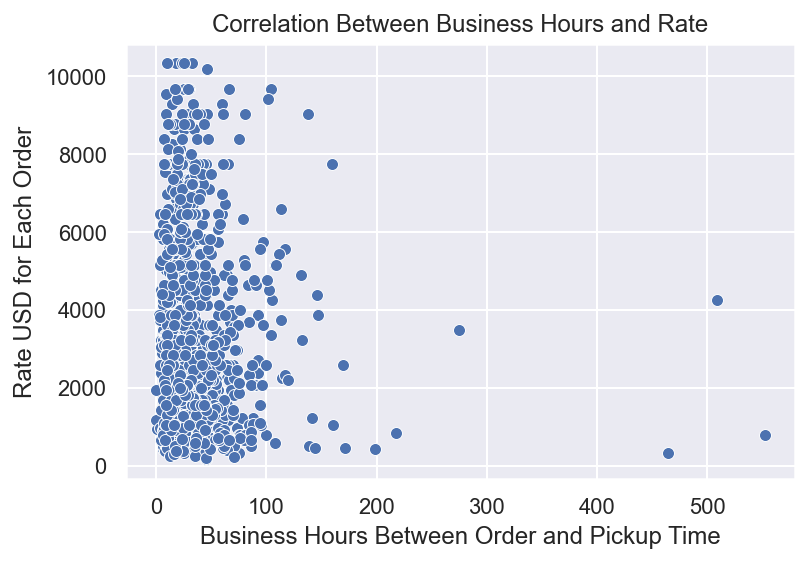

In [15]:
plot4 = sns.scatterplot(x='BUSINESS_HOURS_ORDER_PICKUP', 
                        y='RATE_USD', data=merged.sample(n=1000))

plot4.set_xlabel("Business Hours Between Order and Pickup Time")
plot4.set_ylabel("Rate USD for Each Order")
plot4.set_title("Correlation Between Business Hours and Rate")

In [16]:
merged["ORIGIN_CITY"].value_counts()[:20]

Rancho Cucamonga CA    84929
Atlanta GA             57155
Dallas TX              55058
Whittier CA            30671
San Bernardino CA      29907
Los Angeles CA         29370
Oakland CA             29139
Fort Worth TX          25147
Stockton CA            20057
Riverside CA           18899
Long Beach CA          16470
Houston TX             16319
Anaheim CA             14779
Tacoma WA              14581
Sacramento CA          13361
Miami FL               13218
San Diego CA           13031
Seattle WA             11221
San Antonio TX         10385
Charlotte NC            9560
Name: ORIGIN_CITY, dtype: int64

In [17]:
merged["DESTINATION_CITY"].value_counts()[:20]

Dallas TX              37448
San Bernardino CA      28923
Atlanta GA             24947
Chicago IL             24297
Stockton CA            20116
Rancho Cucamonga CA    18165
Houston TX             15315
Oakland CA             15023
San Antonio TX         14266
Portland OR            14020
Los Angeles CA         13944
Riverside CA           13728
Seattle WA             13207
Tacoma WA              12664
San Diego CA           12613
Denver CO              12528
Phoenix AZ             12370
Sacramento CA          11752
Charlotte NC           11077
Las Vegas NV           11011
Name: DESTINATION_CITY, dtype: int64

Analysis:

After parsing the zipcodes to actual cities and states, we counted the values of each unique city and state. We found that some of the top 20 popular cities and states in the origin are not prosperous places, such as Rancho Cucamonga and Whittier. But for the top 20 popular cities and states in the distination are mostly big cities and towns in a state, such as Dallas, San Bernardino, Atlanta, and Chicago. The geographic information is an important feature to analyze, so we will do OneHotEncoding when we are creating our models later.

In [18]:
order_month = pd.DataFrame(merged["ORDER_MONTH"].value_counts()).sort_index()
order_day = pd.DataFrame(merged["ORDER_DAY"].value_counts()).sort_index()
order_hour = pd.DataFrame(merged["ORDER_HOUR"].value_counts()).sort_index()

pickup_month = pd.DataFrame(merged["PICKUP_MONTH"].value_counts()).sort_index()
pickup_day = pd.DataFrame(merged["PICKUP_DAY"].value_counts()).sort_index()
pickup_hour = pd.DataFrame(merged["PICKUP_HOUR"].value_counts()).sort_index()

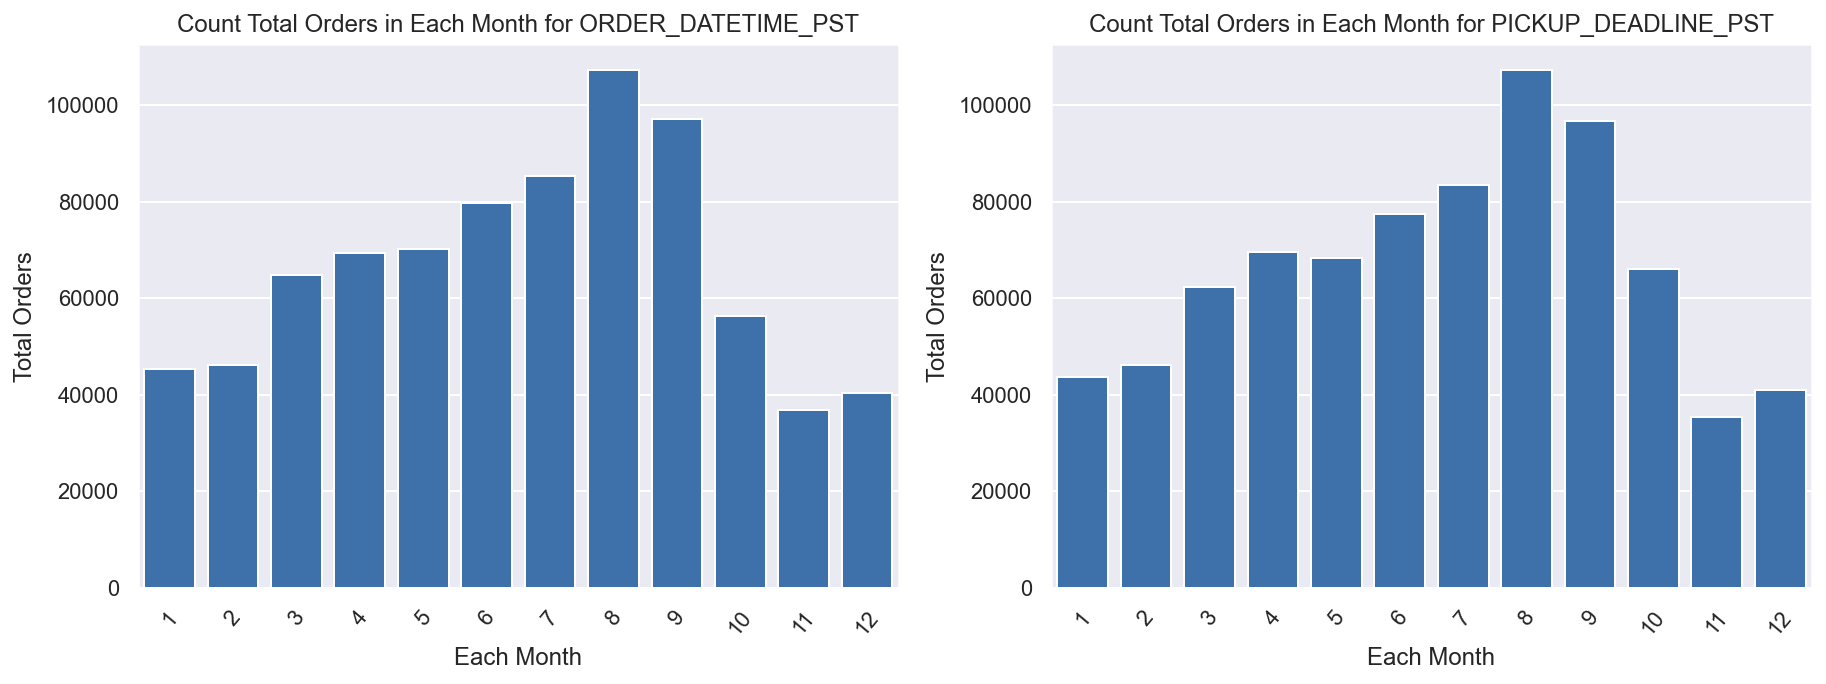

In [19]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

bar1 = sns.barplot(ax=axes[0], data=order_month, 
                   x=order_month.index, y="ORDER_MONTH", color=sns.xkcd_rgb["medium blue"])

bar1.set_xlabel("Each Month")
bar1.set_ylabel("Total Orders")
bar1.set_title("Count Total Orders in Each Month for ORDER_DATETIME_PST")
bar1.tick_params(axis="x", rotation=50)

bar2 = sns.barplot(ax=axes[1], data=pickup_month, 
                   x=pickup_month.index, y="PICKUP_MONTH", color=sns.xkcd_rgb["medium blue"])

bar2.set_xlabel("Each Month")
bar2.set_ylabel("Total Orders")
bar2.set_title("Count Total Orders in Each Month for PICKUP_DEADLINE_PST")
bar2.tick_params(axis="x", rotation=50)

Analysis:

As we compared ORDER_MONTH and PICKUP_MONTH, we could see that the distributions of the two are really similar. The month that has the most count for ORDER_MONTH is the same as PICKUP_MONTH, which is August. The month that has the least count for ORDER_MONTH is the same as PICKUP_MONTH, which is November.

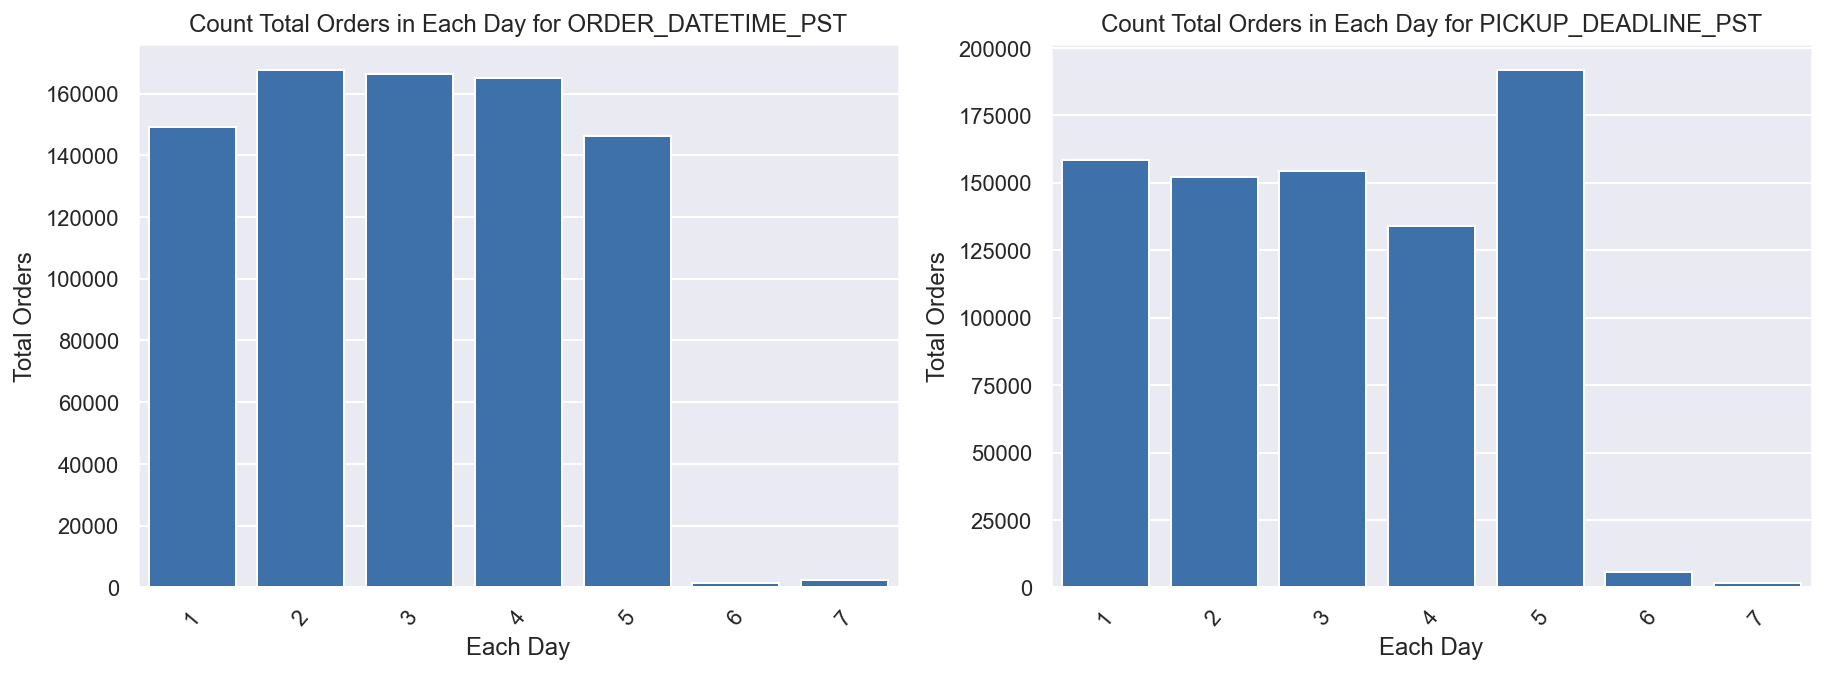

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

bar3 = sns.barplot(ax=axes[0], data=order_day, 
                   x=np.arange(1, 8), y="ORDER_DAY", color=sns.xkcd_rgb["medium blue"])

bar3.set_xlabel("Each Day")
bar3.set_ylabel("Total Orders")
bar3.set_title("Count Total Orders in Each Day for ORDER_DATETIME_PST")
bar3.tick_params(axis="x", rotation=50)

bar4 = sns.barplot(ax=axes[1], data=pickup_day, 
                   x=np.arange(1, 8), y="PICKUP_DAY", color=sns.xkcd_rgb["medium blue"])

bar4.set_xlabel("Each Day")
bar4.set_ylabel("Total Orders")
bar4.set_title("Count Total Orders in Each Day for PICKUP_DEADLINE_PST")
bar4.tick_params(axis="x", rotation=50)

Analysis:

As we compared ORDER_DAY and PICKUP_DAY, we could see that Tuesday, Wednesday, and Thursday have a similar count for ORDER_DAY, over 160,000. However, the day that has the least count is Sunday. For PICKUP_DAY, the day that has the most count is Friday, with over 175,000, and the least count is Sunday.

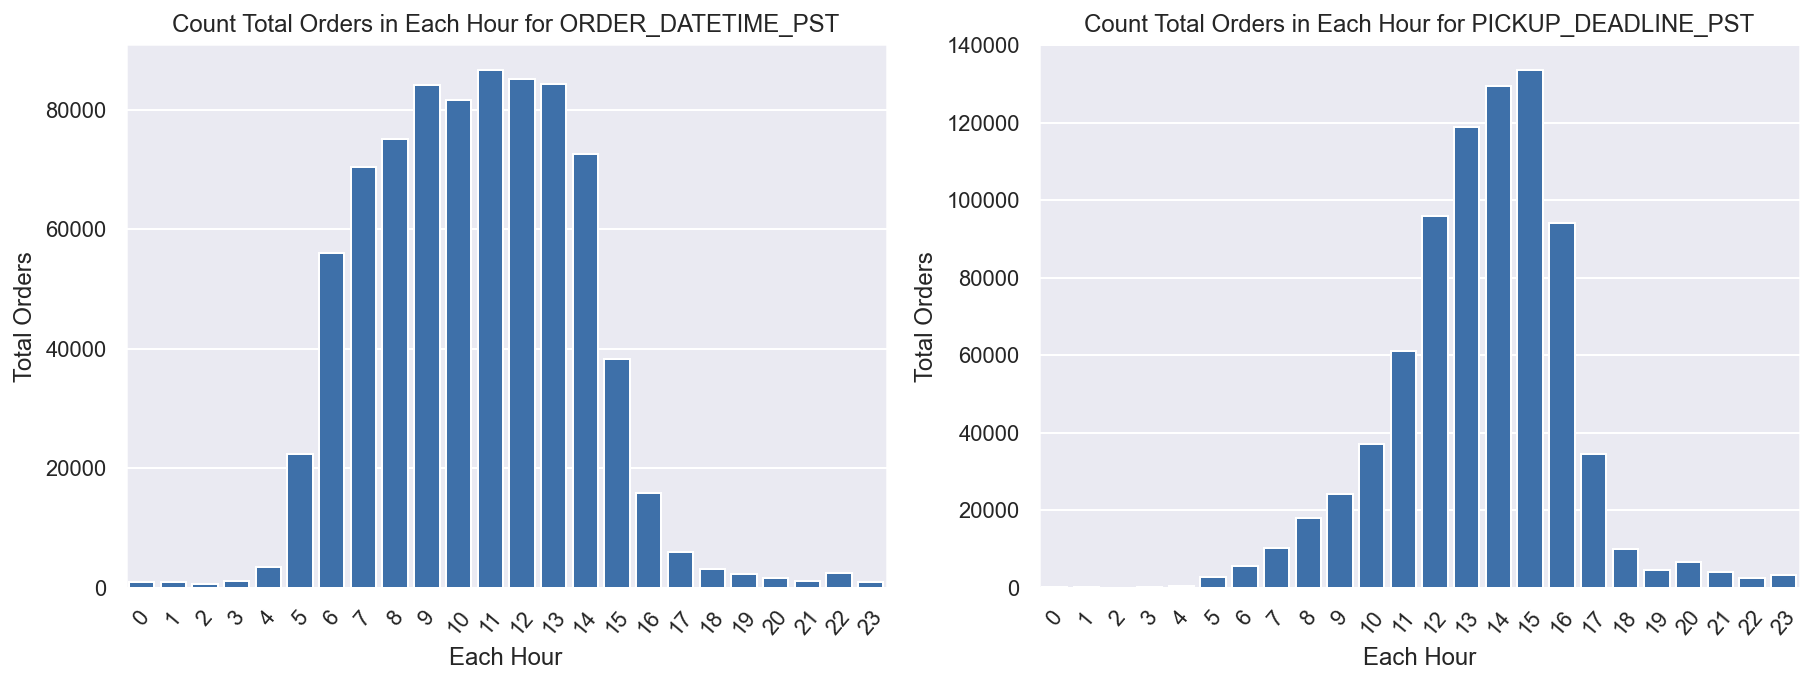

In [21]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))

bar5 = sns.barplot(ax=axes[0], data=order_hour, 
                   x=order_hour.index, y="ORDER_HOUR", color=sns.xkcd_rgb["medium blue"])

bar5.set_xlabel("Each Hour")
bar5.set_ylabel("Total Orders")
bar5.set_title("Count Total Orders in Each Hour for ORDER_DATETIME_PST")
bar5.tick_params(axis="x", rotation=50)

bar6 = sns.barplot(ax=axes[1], data=pickup_hour, 
                   x=pickup_hour.index, y="PICKUP_HOUR", color=sns.xkcd_rgb["medium blue"])

bar6.set_xlabel("Each Hour")
bar6.set_ylabel("Total Orders")
bar6.set_title("Count Total Orders in Each Hour for PICKUP_DEADLINE_PST")
bar6.tick_params(axis="x", rotation=50)

Analysis:

As we compared ORDER_HOUR and PICKUP_HOUR, we could see that the hour that has the most count for ORDER_HOUR is 11AM and the least count is 2AM. In addition, the hour that has the most count for PICKUP_HOUR is 3PM. The plot has no data showing from 12AM to 3AM, so there are only a few orders that are in this time range.

In [22]:
# import geopandas
# import pandas as pd
# import pandas_bokeh
# import matplotlib.pyplot as plt
# pandas_bokeh.output_notebook()

# canada = geopandas.read_file("./gfsa000b11a_e.shp")
# ontario = canada[canada['PRUID'] == '35']

# # Sample data to plot
# df=pd.DataFrame({'PCODE': ['P0V','P0L','P0T','P0Y', 'P0G', 'P2N'], 'A':[6,3,5,2,2,4] })

# # Join ontario dataset with sample data
# new_df=ontario.join(df.set_index('PCODE'), on='CFSAUID')


# new_df.plot_bokeh(simplify_shapes=20000,
#                   category="A", 
#                   colormap="Spectral", 
#                   hovertool_columns=["CFSAUID","A"])

In [ ]:

client = Client()
client


import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd
import numpy as np
import json


def PA0(user_reviews_csv):
    client = Client()
    client = client.restart()

    # ensure to use the parameter name i.e user_reviews_csv instead of hardcoding the filename inside read_csv func
    # for eg. dd.read_csv('user_reviews_Release.csv') is hardcoding and incorrect
    # instead leave it as dd.read_csv(user_reviews_csv) that is the parameter as set in the function signature.

    

    # ensure that you have replaced <YOUR_USERS_DATAFRAME> with your final dataframe.
    submit = <YOUR_USERS_DATAFRAME>.describe().compute().round(2)    
    with open('results_PA0.json', 'w') as outfile: json.dump(json.loads(submit.to_json()), outfile)

# do not type anything outside this function, we would be calling your function from a different python notebook
# and passing in our hidden dataset as the parameter, which should then function correctly.



reviews_full = dd.read_csv("user_reviews_Release.csv")
reviews = reviews_full.sample(frac=0.005)

reviews["reviewing_since"] = reviews["reviewTime"].apply(lambda date: int(date[-4:]), meta=("review_year", int))
reviews["helpful_votes"] = reviews["helpful"].apply(lambda vote: int(vote.split(", ")[0][1:]), meta=("helpful_count", int))
reviews["total_votes"] = reviews["helpful"].apply(lambda vote: int(vote.split(", ")[1][:-1]), meta=("vote_count", int))

reviews = reviews[["overall", "reviewing_since", "helpful_votes", "total_votes"]]
reviews = reviews.rename(columns={"overall": "avg_ratings"})


reviews.head(15).describe()